<a href="https://colab.research.google.com/github/robertrose85/WebMining-RecSys/blob/main/RecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/steam-200k-cleansed.csv')

In [ ]:
df.sort_values('PlayTime', ascending=False)

,User,Game,PlayTime
44000,73017395,Sid Meier's Civilization V,11754.0
40143,100630947,Dota 2,10442.0
66141,153382649,Team Fortress 2,9640.0
58816,130882834,Dota 2,7765.0
64980,52567955,Dota 2,6964.0
...,...,...,...
2998,61676491,Prince of Persia The Sands of Time,0.1
2999,61676491,Post Apocalyptic Mayhem,0.1
47422,202894728,Double Action Boogaloo,0.1
14758,274785080,WARMODE,0.1


In [ ]:
df.describe()

,User,PlayTime
count,7.048900e+04,70489.000000
mean,1.058812e+08,48.878063
std,7.150365e+07,229.335236
min,5.250000e+03,0.100000
25%,4.934256e+07,1.000000
50%,9.169067e+07,4.500000
75%,1.556738e+08,19.100000
max,3.099031e+08,11754.000000


In [ ]:
df_norm = df


Because the value ranges are so wide, I think it might be useful to scale the data. Using MinMaxScaler we can scale our PlayTime to be bounded with in 0 and 1.

In [ ]:
#scaler = MinMaxScaler()

#scaler.fit(df_norm[['PlayTime']])
#df_norm['PlayTime'] = scaler.transform(df_norm[['PlayTime']])

#df_norm.sort_values('PlayTime', ascending=False)

In [ ]:
df_norm.describe()

,User,PlayTime
count,7.048900e+04,70489.000000
mean,1.058812e+08,48.878063
std,7.150365e+07,229.335236
min,5.250000e+03,0.100000
25%,4.934256e+07,1.000000
50%,9.169067e+07,4.500000
75%,1.556738e+08,19.100000
max,3.099031e+08,11754.000000


What we see here is that a VAST majority of games have very little playtime, when normalized, much of this play time becomes 0. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c05eac390>,
      dtype=object)

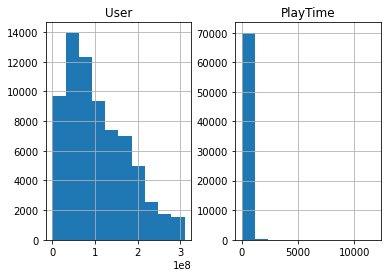

In [ ]:
df.hist()

In [ ]:
matrix = df_norm.pivot_table(columns='Game', index='User', values='PlayTime')#.reset_index()
matrix

Game,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,140,15 Days,16bit Trader,1701 A.D. Sunken Dragon,18 Wheels of Steel American Long Haul,1953 NATO vs Warsaw Pact,1Quest,3 Stars of Destiny,3089 -- Futuristic Action RPG,3D Mini Golf,3DMark,3DMark 11,3DMark Vantage,4 Elements,404Sight,500 Years Act 1,60 Seconds!,7 Days to Die,8BitBoy,8BitMMO,9 Clues 2 The Ward,9 Clues The Secret of Serpent Creek,9.03m,99 Levels To Hell,99 Spirits,A Bird Story,A Game of Thrones - Genesis,A Golden Wake,A New Beginning - Final Cut,A Story About My Uncle,...,Zombie Army Trilogy,Zombie Driver,Zombie Driver HD,Zombie Grinder,Zombie Panic Source,Zombie Shooter 2,Zombie Tycoon 2 Brainhov's Revenge,Zombie Zoeds,Zombies Monsters Robots,Zoombinis,Zotrix,Zuma Deluxe,Zuma's Revenge,Zuma's Revenge! - Adventure,aerofly RC 7,bit Dungeon II,eden*,fault milestone one,fault milestone two sideabove,hocus,how do you Do It?,iBomber Attack,iBomber Defense,iBomber Defense Pacific,iO,ibb & obb,inMomentum,liteCam Game 100 FPS Game Capture,oO,planetarian ~the reverie of a little planet~,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
User,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309434439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309554670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN

In [ ]:
matrix = matrix.dropna(thresh=5, axis=0)
matrix

Game,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,140,15 Days,16bit Trader,1701 A.D. Sunken Dragon,18 Wheels of Steel American Long Haul,1953 NATO vs Warsaw Pact,1Quest,3 Stars of Destiny,3089 -- Futuristic Action RPG,3D Mini Golf,3DMark,3DMark 11,3DMark Vantage,4 Elements,404Sight,500 Years Act 1,60 Seconds!,7 Days to Die,8BitBoy,8BitMMO,9 Clues 2 The Ward,9 Clues The Secret of Serpent Creek,9.03m,99 Levels To Hell,99 Spirits,A Bird Story,A Game of Thrones - Genesis,A Golden Wake,A New Beginning - Final Cut,A Story About My Uncle,...,Zombie Army Trilogy,Zombie Driver,Zombie Driver HD,Zombie Grinder,Zombie Panic Source,Zombie Shooter 2,Zombie Tycoon 2 Brainhov's Revenge,Zombie Zoeds,Zombies Monsters Robots,Zoombinis,Zotrix,Zuma Deluxe,Zuma's Revenge,Zuma's Revenge! - Adventure,aerofly RC 7,bit Dungeon II,eden*,fault milestone one,fault milestone two sideabove,hocus,how do you Do It?,iBomber Attack,iBomber Defense,iBomber Defense Pacific,iO,ibb & obb,inMomentum,liteCam Game 100 FPS Game Capture,oO,planetarian ~the reverie of a little planet~,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
User,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303129589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303525289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Na

Let's do some exploratory analysis with our data. As I was looking through the number of titles, I thought that maybe it would be best to trim the data based on the average amount of play. Before I did that, I wanted to see what some of the top games are in terms of average play.

What I found was surprising. If you're a gamer, you might think Skyrim or some popular first person shooter may take the top spot. You would be wrong, it's the legendary Eastside Hockey Manager. When I decided to dig a bit deeper, I found the reason, a single player who really enjoys this game. In fact, most of these titles are skewed by "that guy/girl" who just really enjoys this game that it appears not too many people play.

In [ ]:
df.groupby('Game')['PlayTime'].mean().sort_values(ascending = False).head()

Game
Eastside Hockey Manager              1295.000000
Baldur's Gate II Enhanced Edition     475.255556
FIFA Manager 09                       411.000000
Perpetuum                             400.975000
Football Manager 2014                 391.984615
Name: PlayTime, dtype: float64

Yep. Just one guy.

In [ ]:
df.loc[df['Game'] == 'Eastside Hockey Manager']

,User,Game,PlayTime
68581,213854339,Eastside Hockey Manager,1295.0


Understanding my error, I figured we could at least see what the most popular steam games are using a sum of playtime. This looks better. All of the games listed I've heard of and am very well aware of just how popular they are.

In [ ]:
df.groupby('Game')['PlayTime'].sum().sort_values(ascending = False).head()

Game
Dota 2                             981684.6
Counter-Strike Global Offensive    322771.6
Team Fortress 2                    173673.3
Counter-Strike                     134261.1
Sid Meier's Civilization V          99821.3
Name: PlayTime, dtype: float64

The player count also confirms this.

In [ ]:
df.groupby('Game')['PlayTime'].count().sort_values(ascending = False).head()

Game
Dota 2                             4841
Team Fortress 2                    2323
Counter-Strike Global Offensive    1377
Unturned                           1069
Left 4 Dead 2                       801
Name: PlayTime, dtype: int64

Let's visualize this. First I'll create a dataframe that just has the counts of players for each game.

In [ ]:
game_count = pd.DataFrame(df.groupby('Game')['PlayTime'].count())
game_count = game_count.rename(columns={'PlayTime': 'Player Count'})
game_count.head()

,Player Count
Game,
007 Legends,1
0RBITALIS,3
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),5
10 Second Ninja,2
"10,000,000",1


In [ ]:
game_count['Average Play Time'] = pd.DataFrame(df.groupby('Game')['PlayTime'].mean())

In [ ]:
game_count.sort_values('Player Count', ascending=False).head(20)

,Player Count,Average Play Time
Game,,
Dota 2,4841,202.785499
Team Fortress 2,2323,74.762505
Counter-Strike Global Offensive,1377,234.402033
Unturned,1069,15.057437
Left 4 Dead 2,801,41.943446
Counter-Strike Source,715,134.371329
The Elder Scrolls V Skyrim,677,104.710931
Garry's Mod,666,74.662613
Counter-Strike,568,236.375176


In [ ]:
zero = matrix.isna().sum().sum()
zero

8711823

In [ ]:
total_val = np.product(matrix.shape)
total_val

8769600

In [ ]:
sparsity = (zero/total_val)
sparsity*100

99.34116721401203

In [ ]:
density = 1-sparsity
density

0.006588327859879617

In [ ]:
print(density+sparsity)

1.0


When I began running my correlations at the end, I discovered some bizarre correlations. While they kind of made sense, they didn't seem logical. So what I did was take a look at our matrix and adjusted our NaN ratings to be 0. From our [lectures](https://www.youtube.com/watch?v=3Sl_nFQbLQA), I understood that this is typically how cosine similarity is done, but this is not optimal for recommenders. What happens is that this tends to skew our data.

In [ ]:
matrix = df_norm.pivot_table(columns='Game', index='User', values='PlayTime', fill_value=0)
matrix

Game,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,140,15 Days,16bit Trader,1701 A.D. Sunken Dragon,18 Wheels of Steel American Long Haul,1953 NATO vs Warsaw Pact,1Quest,3 Stars of Destiny,3089 -- Futuristic Action RPG,3D Mini Golf,3DMark,3DMark 11,3DMark Vantage,4 Elements,404Sight,500 Years Act 1,60 Seconds!,7 Days to Die,8BitBoy,8BitMMO,9 Clues 2 The Ward,9 Clues The Secret of Serpent Creek,9.03m,99 Levels To Hell,99 Spirits,A Bird Story,A Game of Thrones - Genesis,A Golden Wake,A New Beginning - Final Cut,A Story About My Uncle,...,Zombie Army Trilogy,Zombie Driver,Zombie Driver HD,Zombie Grinder,Zombie Panic Source,Zombie Shooter 2,Zombie Tycoon 2 Brainhov's Revenge,Zombie Zoeds,Zombies Monsters Robots,Zoombinis,Zotrix,Zuma Deluxe,Zuma's Revenge,Zuma's Revenge! - Adventure,aerofly RC 7,bit Dungeon II,eden*,fault milestone one,fault milestone two sideabove,hocus,how do you Do It?,iBomber Attack,iBomber Defense,iBomber Defense Pacific,iO,ibb & obb,inMomentum,liteCam Game 100 FPS Game Capture,oO,planetarian ~the reverie of a little planet~,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
User,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309434439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
309554670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
def center(row):
  new_row = (row - row.mean()) / (row.max() - row.min())
  return new_row

matrix_std = matrix.apply(center)

Game,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,140,15 Days,16bit Trader,1701 A.D. Sunken Dragon,18 Wheels of Steel American Long Haul,1953 NATO vs Warsaw Pact,1Quest,3 Stars of Destiny,3089 -- Futuristic Action RPG,3D Mini Golf,3DMark,3DMark 11,3DMark Vantage,4 Elements,404Sight,500 Years Act 1,60 Seconds!,7 Days to Die,8BitBoy,8BitMMO,9 Clues 2 The Ward,9 Clues The Secret of Serpent Creek,9.03m,99 Levels To Hell,99 Spirits,A Bird Story,A Game of Thrones - Genesis,A Golden Wake,A New Beginning - Final Cut,A Story About My Uncle,...,Zombie Driver,Zombie Driver HD,Zombie Grinder,Zombie Panic Source,Zombie Shooter 2,Zombie Tycoon 2 Brainhov's Revenge,Zombie Zoeds,Zombies Monsters Robots,Zoombinis,Zotrix,Zuma Deluxe,Zuma's Revenge,Zuma's Revenge! - Adventure,aerofly RC 7,bit Dungeon II,eden*,fault milestone one,fault milestone two sideabove,hocus,how do you Do It?,iBomber Attack,iBomber Defense,iBomber Defense Pacific,iO,ibb & obb,inMomentum,liteCam Game 100 FPS Game Capture,oO,planetarian ~the reverie of a little planet~,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal,sum
User,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5250,-0.000088,-0.000176,-0.000157,-0.000096,-0.000088,-0.000197,-0.000088,-0.000312,-0.000206,-0.000145,-0.000278,-0.000088,-0.000167,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,-0.000125,-0.000088,-0.000088,-0.000141,-0.000251,-0.000088,-0.000228,-0.00058,-0.0001,-0.000452,-0.000088,-0.000235,-0.000088,-0.000113,-0.000088,-0.000341,-0.000152,-0.000088,-0.000183,-0.000148,...,-0.000262,-0.000107,-0.000088,-0.000194,-0.000101,-0.000088,-0.000137,-0.000356,-0.000088,-0.000088,-0.000088,-0.000095,-0.000098,-0.000088,-0.000157,-0.000117,-0.000088,-0.000088,-0.000088,-0.000176,-0.000088,-0.000146,-0.000123,-0.000088,-0.000267,-0.000147,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,-0.00011,-0.000139,-0.000403,-0.000088,-0.000746,-0.000352,-0.000287,-0.000107,0.022052
76767,-0.000088,-0.000176,-0.000157,-0.000096,-0.000088,-0.000197,-0.000088,-0.000312,-0.000206,-0.000145,-0.000278,-0.000088,-0.000167,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,-0.000125,-0.000088,-0.000088,-0.000141,-0.000251,-0.000088,-0.000228,-0.00058,-0.0001,-0.000452,-0.000088,-0.000235,-0.000088,-0.000113,-0.000088,-0.000341,-0.000152,-0.000088,-0.000183,-0.000148,...,-0.000262,-0.000107,-0.000088,-0.000194,-0.000101,-0.000088,-0.000137,-0.000356,-0.000088,-0.000088,-0.000088,-0.000095,-0.000098,-0.000088,-0.000157,-0.000117,-0.000088,-0.000088,-0.000088,-0.000176,-0.000088,-0.000146,-0.000123,-0.000088,-0.000267,-0.000147,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,-0.00011,-0.000139,-0.000403,-0.000088,-0.000746,-0.000352,-0.000287,-0.000107,1.385991
86540,-0.000088,-0.000176,-0.000157,-0.000096,-0.000088,-0.000197,-0.000088,-0.000312,-0.000206,-0.000145,-0.000278,-0.000088,-0.000167,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,-0.000125,-0.000088,-0.000088,-0.000141,-0.000251,-0.000088,-0.000228,-0.00058,-0.0001,-0.000452,-0.000088,-0.000235,-0.000088,-0.000113,-0.000088,-0.000341,-0.000152,-0.000088,-0.000183,-0.000148,...,-0.000262,-0.000107,-0.000088,-0.000194,-0.000101,-0.000088,-0.000137,-0.000356,-0.000088,-0.000088,-0.000088,-0.000095,-0.000098,-0.000088,-0.000157,-0.000117,-0.000088,-0.000088,-0.000088,-0.000176,-0.000088,-0.000146,-0.000123,-0.000088,-0.000267,-0.000147,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,-0.00011,-0.000139,-0.000403,-0.000088,-0.000746,-0.000352,-0.000287,-0.000107,0.613886
144736,-0.000088,-0.000176,-0.000157,-0.000096,-0.000088,-0.000197,-0.000088,-0.000312,-0.000206,-0.

Considering how sparse our matrix is, and considering how large it is, I'm not surprised by what I see. From here, I'll drop the null values.

In [ ]:
def gameRec(g):
  dota = matrix_std[g]

  #Calculate Pearson Sim with all other games.
  dota = matrix.corrwith(dota).dropna() 

  #create a DF to show how many times each game has been played and the mean time it has been played
  gameData = df_norm.groupby('Game').agg({'PlayTime': [np.size, np.mean]}) 

  #Filter out any game played by less than 100 players.
  gameSim = gameData['PlayTime']['size'] >= 100 

  df = gameData[gameSim].join(pd.DataFrame(dota, columns=['similarity']))

  return df.sort_values(['similarity'], ascending=False)[:5]


gameRec('The Elder Scrolls V Skyrim')

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,"(PlayTime, size)","(PlayTime, mean)",similarity
Game,,,
The Elder Scrolls V Skyrim,677.0,104.710931,1.000000
Far Cry 3,181.0,28.044199,0.226599
Fallout New Vegas,287.0,51.682578,0.218436
Fallout 4,167.0,64.447904,0.201649
Deus Ex Human Revolution,138.0,25.995652,0.190528


In [ ]:
game_sim = cosine_similarity(matrix_std.T)

In [ ]:
game_sim_df = pd.DataFrame(game_sim, index=matrix_std.columns, columns=matrix_std.columns)
game_sim_df

Game,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,140,15 Days,16bit Trader,1701 A.D. Sunken Dragon,18 Wheels of Steel American Long Haul,1953 NATO vs Warsaw Pact,1Quest,3 Stars of Destiny,3089 -- Futuristic Action RPG,3D Mini Golf,3DMark,3DMark 11,3DMark Vantage,4 Elements,404Sight,500 Years Act 1,60 Seconds!,7 Days to Die,8BitBoy,8BitMMO,9 Clues 2 The Ward,9 Clues The Secret of Serpent Creek,9.03m,99 Levels To Hell,99 Spirits,A Bird Story,A Game of Thrones - Genesis,A Golden Wake,A New Beginning - Final Cut,A Story About My Uncle,...,Zombie Driver,Zombie Driver HD,Zombie Grinder,Zombie Panic Source,Zombie Shooter 2,Zombie Tycoon 2 Brainhov's Revenge,Zombie Zoeds,Zombies Monsters Robots,Zoombinis,Zotrix,Zuma Deluxe,Zuma's Revenge,Zuma's Revenge! - Adventure,aerofly RC 7,bit Dungeon II,eden*,fault milestone one,fault milestone two sideabove,hocus,how do you Do It?,iBomber Attack,iBomber Defense,iBomber Defense Pacific,iO,ibb & obb,inMomentum,liteCam Game 100 FPS Game Capture,oO,planetarian ~the reverie of a little planet~,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal,sum
Game,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
007 Legends,1.000000,-0.000144,-0.000140,-0.000096,-0.000088,-0.000147,-0.000088,-0.000202,-0.000162,-0.000132,-0.000182,-0.000088,-0.000124,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,-0.000123,-0.000088,-0.000088,-0.000132,-0.000191,-0.000088,-0.000176,-0.000362,-0.000100,-0.000310,-0.000088,-0.000156,-0.000088,-0.000111,-0.000088,-0.000218,-0.000144,-0.000088,-0.000140,-0.000136,...,-0.000199,-0.000106,-0.000088,-0.000173,-0.000100,-0.000088,-0.000120,-0.000261,-0.000088,-0.000088,-0.000088,-0.000095,-0.000098,-0.000088,-0.000124,-0.000111,-0.000088,-0.000088,-0.000088,-0.000138,-0.000088,-0.000122,-0.000117,-0.000088,-0.000157,-0.000122,-0.000088,-0.000088,-0.000088,-0.000088,-0.000088,-0.000108,-0.000120,-0.000232,-0.000088,-0.000413,-0.000224,-0.000261,-0.000105,0.024954
0RBITALIS,-0.000144,1.000000,-0.000229,0.075136,-0.000144,-0.000240,-0.000144,-0.000329,-0.000264,-0.000215,-0.000297,-0.000144,-0.000203,-0.000144,-0.000144,-0.000144,-0.000144,-0.000144,-0.000144,-0.000144,-0.000201,-0.000144,-0.000144,-0.000215,-0.000312,-0.000144,-0.000288,-0.000591,-0.000163,-0.000506,-0.000144,-0.000254,-0.000144,-0.000181,-0.000144,-0.000357,-0.000235,-0.000144,-0.000228,-0.000221,...,-0.000325,-0.000172,-0.000144,-0.000282,-0.000164,-0.000144,-0.000196,-0.000426,-0.000144,-0.000144,-0.000144,-0.000155,-0.000160,-0.000144,-0.000202,-0.000181,-0.000144,-0.000144,-0.000144,-0.000226,-0.000144,-0.000199,-0.000191,-0.000144,-0.000257,-0.000200,-0.000144,-0.000144,-0.000144,-0.000144,-0.000144,-0.000177,-0.000197,-0.000379,-0.000144,-0.000675,-0.000366,0.003490,-0.000172,0.033145
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),-0.000140,-0.000229,1.000000,-0.000153,-0.000140,-0.000234,-0.000140,-0.000321,-0.000258,-0.000210,-0.000290,-0.000140,-0.000198,-0.000140,-0.000140,-0.000140,-0.000140,-0.000140,-0.000140,-0.000140,-0.000196,-0.000140,-0.000140,-0.000210,-0.000304,-0.000140,-0.000281,0.000464,0.010963,0.127112,-0.000140,-0.000248,-0.000140,-0.000176,-0.000140,-0.000348,-0.000229,-0.000140,-0.000222,-0.000216,...,0.231703,-0.000168,-0.000140,0.002329,-0.000160,-0.000140,-0.000191,-0.000415,-0.000140,-0.000140,-0.000140,-0.000152,-0.000156,-0.000140,-0.000197,-0.000177,-0.000140,-0.000140,-0.000140,-0.000220,-0.000140,-0.000194,-0.000187,-0.000140,-0.000250,-0.000195,-0.000140,-0.000140,-0.000140,-0.000140,-0.000140,-0.000172,-0.000192,-0.000369,-0.000140,0.000922,-0.000357,-0.000416,-0.000168,0.109348
10 Second Ninja,-0.000096,0.075136,

In [ ]:
def get_games(game, playtime):
  sim = game_sim_df[game]*playtime
  sim = sim.sort_values(ascending=False)

  return sim

print(get_games('Half-Life 2', 100))


Game
Half-Life 2                       100.000000
Half-Life 2 Episode One            68.217622
Half-Life 2 Episode Two            63.682597
Portal                             28.529621
Portal 2                           27.277151
                                     ...    
The Mighty Quest For Epic Loot     -0.344571
BLOCKADE 3D                        -0.362376
Football Manager 2016              -0.402572
FreeStyle2 Street Basketball       -0.431248
Football Manager 2015              -0.550063
Name: Half-Life 2, Length: 3601, dtype: float64


In [ ]:
gamer = [('Dishonored', 150), ('Napoleon Total War', 200), ('Spore', 200)]

gamer_df = pd.DataFrame()

for game, play in gamer:
  gamer_df = gamer_df.append(get_games(game,play), ignore_index=True)


gamer_df.sum().sort_values(ascending=False)[:20]


Spore                                    202.694927
Napoleon Total War                       201.181443
Dishonored                               154.465176
Empire Total War                          97.933771
Total War SHOGUN 2                        97.601362
Frontlines Fuel of War                    95.418062
Tom Clancy's Splinter Cell Conviction     93.630059
Sid Meier's Civilization Beyond Earth     92.619696
RAGE                                      91.983853
Metro 2033                                91.802619
Metro Last Light                          90.051989
PROTOTYPE 2                               82.937091
Crysis 2                                  79.212681
Sid Meier's Starships                     77.131070
Far Cry 2                                 77.000510
Transformers War for Cybertron            75.968134
Mount & Blade Warband                     75.248866
Prototype                                 71.328674
Borderlands The Pre-Sequel                68.731982
Mount & Blad

In [ ]:
dota = matrix_std['Dishonored']
dota.head()

User
5250     -0.000813
76767    -0.000813
86540    -0.000813
144736   -0.000813
181212   -0.000813
Name: Dishonored, dtype: float64

In [ ]:
dota = matrix.corrwith(dota)
dota

Game
007 Legends                                                  -0.000553
0RBITALIS                                                     0.032833
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)   -0.000881
10 Second Ninja                                               0.002555
10,000,000                                                    0.070147
                                                                ...   
rymdkapsel                                                   -0.000553
sZone-Online                                                 -0.002265
the static speaks my name                                     0.004095
theHunter                                                     0.000559
theHunter Primal                                              0.088949
Length: 3600, dtype: float64

In [ ]:
dota = dota.dropna()
dota.head()

Game
007 Legends                                                  -0.000553
0RBITALIS                                                     0.032833
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)   -0.000881
10 Second Ninja                                               0.002555
10,000,000                                                    0.070147
dtype: float64

In [ ]:
dota_df = pd.DataFrame(dota)
dota_df = dota_df.rename(columns={0: 'Correlation'})
dota_df

,Correlation
Game,
007 Legends,-0.000553
0RBITALIS,0.032833
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),-0.000881
10 Second Ninja,0.002555
"10,000,000",0.070147
...,...
rymdkapsel,-0.000553
sZone-Online,-0.002265
the static speaks my name,0.004095


If we sort the values, we only get each extreme correlation, -1 or 1. To make things worse, no one has heard of any of these games. Despite what we see, I can't go ahead and tell someone who's played "Dota 2" that they'd really enjoy "Burgers". But if you recall, we have a very high sparsity matrix, so these odd correlations are bound to pop up due to games that have only been played by a few people.

In [ ]:
dota_df.sort_values('Correlation')

,Correlation
Game,
Dota 2,-0.006858
Counter-Strike,-0.003786
Mitos.is The Game,-0.002752
Football Manager 2015,-0.002468
Counter-Strike Condition Zero,-0.002400
...,...
Metro 2033,0.604619
RAGE,0.612961
Tom Clancy's Splinter Cell Conviction,0.618950


In [ ]:
gameData = df_norm.groupby('Game').agg({'PlayTime': [np.size, np.mean]})

gameSim = gameData['PlayTime']['size'] >= 100
#gameData[gameSim].sort_values([('PlayTime', 'mean')], ascending=False)[:15]

df = gameData[gameSim].join(pd.DataFrame(dota, columns=['similarity']))



/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [ ]:
df.sort_values(['similarity'], ascending=False)[:5]

,"(PlayTime, size)","(PlayTime, mean)",similarity
Game,,,
Dishonored,145.0,19.601379,1.000000
Metro 2033,175.0,8.946857,0.604619
Deus Ex Human Revolution,138.0,25.995652,0.403862
Just Cause 2,186.0,18.588710,0.330753
Borderlands 2,386.0,58.725130,0.320486
